### Experiment 2 - Table 2

Calculating test accuracy and robustness (adversarial accuracy, adv. acc) for different datasets and different settings, given Trimmed mean and median aggregation schemes

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd
import gc

import torch.nn.functional as F
import re

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from utils.util_notebooks import set_args, import_model_weights, get_adv_acc
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *





/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 20
exp = "cifar10"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/231031_FAT150round/FAT/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/230922_baseline_train/fedavg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
step_size = 0.01
steps = 10

In [ ]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..


 24%|██▍       | 19/80 [00:00<00:00, 115.84it/s]


===> Initializing clients..


  0%|          | 0/20 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


In [5]:
# aggregator.load_state(dir_path=save_path_FAT)
# aggregator.update_clients()
# aggregation_op = 'trimmed_mean'
# aggregator.op = aggregation_op
# weight_scale_2 = 1
# atk_rounds = 1
# tm_beta = 0
# adv_id = [0]

# model_inject = model_Fedavg
# keys = desired_keys

# ################################# Code starts here

# weight_scale = 1/aggregator.clients_weights
# model_global = aggregator.global_learners_ensemble[0].model

# # if aggregation_op == None:
# #     aggregation_op = aggregator.aggregation_op
    
# # Based on aggregation methods change weight scale
# if aggregation_op in ['median', 'krum', 'median_sublayers']:# == "median" or aggregation_op == "krum":
#     weight_scale = np.ones(weight_scale.shape)

# if aggregation_op in ['trimmed_mean']: # simple averaging takes place instead of weighted
#     N_removed = int(tm_beta*len(aggregator.clients))
#     weight_scale = np.ones(len(aggregator.clients))  * (len(aggregator.clients)-N_removed*2)
#     print("trimmed mean, N removed: ", N_removed)
#     print("weight scale: \n", weight_scale)

# # Give adversarial clients boosted models and train regular clients 1 round
# benign_id = list(range(len(aggregator.clients)))

# for a_id in adv_id:
#     benign_id.remove(a_id)
#     temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)

# for c_id in benign_id:
#     aggregator.clients[c_id].step()

# learner_id = 0
# global_learner = aggregator.global_learners_ensemble[learner_id]
# learners =  [client.learners_ensemble[learner_id] for client in [aggregator.clients[i] for i in benign_id]]
# adjusted_weights = torch.from_numpy((1/weight_scale)[benign_id] / np.sum( (1/weight_scale)[benign_id]))
# average_learners(learners, global_learner, weights=adjusted_weights)

# model_global_updated = aggregator.global_learners_ensemble[0].model

# ############# - Unmix temp atk model - ###########
# reverse_model = undo_calc_atk_model(temp_atk_model, model_global_updated, keys, weight_scale[a_id], weight_scale_2)


In [6]:
x_min = torch.min(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
x_max = torch.max(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
import torch
import torch.nn.functional as F

def calculate_accuracy(model, x_data, y_data):
    """
    Calculate accuracy of a model on given data.

    Args:
        model: The model to evaluate (e.g., model_Fedavg or model_FAT).
        x_data: The input data (tensor).
        y_data: The ground truth labels (tensor).

    Returns:
        Accuracy as a percentage (float).
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Forward pass
        outputs = model(x_data.cuda())  # Make sure input is on GPU
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        correct = (predicted == y_data.cuda()).sum().item()  # Count correct predictions
        accuracy = correct / len(y_data) * 100  # Calculate accuracy percentage
    return accuracy

c_id = 3

# Load client data
dataloader = load_client_data(clients=aggregator.clients, c_id=c_id, mode='test')
# x_data = copy.deepcopy(dataloader.x_data.to(torch.float32).cuda())  # Convert to float32 and move to GPU
# y_data = dataloader.y_data.cuda()  # Move ground truth to GPU

# Generate adversarial data (x_adv)
atk_params = PGD_Params()
atk_params.set_params(batch_size=50, iteration=steps,
                target=-1, x_val_min=x_min, x_val_max=x_max,
                step_size=step_size, step_norm="inf", eps=eps_attack, eps_norm=2)

combined_model = aggregator.clients[0].combine_learners_ensemble()
generator = Adv_NN(model_Fedavg, dataloader)

# Perform adversarial attack
generator.pgd(atk_params, print_info = True)
x_adv = generator.x_adv.to(torch.float32).cuda()  # Convert to float32 and move to GPU
x_data = generator.x_orig.to(torch.float32).cuda()
y_data = generator.y_orig.cuda()

generator2 = Adv_NN(model_FAT, dataloader)
generator.pgd(atk_params, print_info = True)

# Calculate accuracy for x_data and x_adv using model_Fedavg and model_FAT
accuracy_fedavg_x_data = calculate_accuracy(model_Fedavg, x_data, y_data)
accuracy_fedavg_x_adv = calculate_accuracy(model_Fedavg, x_adv, y_data)

accuracy_fat_x_data = calculate_accuracy(model_FAT, x_data, y_data)
accuracy_fat_x_adv = calculate_accuracy(model_FAT, x_adv, y_data)

# Print out the results
print(f"Accuracy of model_Fedavg on clean data (x_data): {accuracy_fedavg_x_data:.2f}%")
print(f"Accuracy of model_Fedavg on adversarial data (x_adv): {accuracy_fedavg_x_adv:.2f}%")

print(f"Accuracy of model_FAT on clean data (x_data): {accuracy_fat_x_data:.2f}%")
print(f"Accuracy of model_FAT on adversarial data (x_adv): {accuracy_fat_x_adv:.2f}%")


---- FGSM Batch Size: 50 ----

Orig Target: [0, 8, 0, 8, 8, 8, 12, 2, 8, 4, 0, 4, 0, 8, 8, 9, 0, 5, 8, 4, 12, 12, 0, 4, 8, 12, 4, 8, 0, 8, 4, 4, 8, 0, 4, 4, 0, 4, 4, 8, 0, 12, 0, 8, 8, 0, 12, 8, 4, 8]
Orig Output: [0, 0, 0, 8, 8, 8, 12, 2, 8, 4, 8, 4, 4, 0, 8, 9, 0, 13, 8, 4, 4, 12, 0, 4, 8, 12, 4, 8, 0, 8, 4, 4, 8, 4, 8, 6, 0, 6, 4, 8, 0, 12, 0, 8, 8, 0, 12, 8, 4, 8]
ADV Output : [13, 0, 11, 4, 2, 0, 8, 14, 4, 8, 8, 8, 12, 1, 6, 4, 8, 14, 1, 0, 5, 1, 8, 13, 10, 0, 10, 13, 12, 1, 12, 10, 4, 14, 9, 14, 5, 14, 13, 13, 14, 5, 12, 0, 0, 14, 5, 4, 12, 5] 

Orig Loss  : -13.831871032714844
ADV Loss   : 5.941608428955078 

Orig Acc   : 0.7999999523162842
ADV Acc    : 0.0
---- FGSM Batch Size: 50 ----

Orig Target: [12, 0, 12, 12, 0, 12, 8, 12, 0, 4, 0, 4, 4, 0, 12, 2, 8, 0, 4, 4, 4, 4, 0, 12, 8, 0, 0, 0, 0, 0, 5, 12, 12, 12, 2, 4, 14, 8, 4, 8, 4, 4, 4, 8, 4, 8, 0, 12, 0, 0]
Orig Output: [14, 0, 12, 12, 0, 12, 8, 12, 0, 4, 0, 4, 4, 0, 4, 0, 0, 0, 4, 0, 4, 4, 8, 12, 8, 0, 0, 0, 0, 0, 5, 12, 8, 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Submodule Name                 Mean Cosine Similarity         Std Dev
features.0                               0.97798049      0.00552061 
features.1                               0.83534741      0.01938468 !!!
features.2                               0.82017720      0.02216417 !!!
features.3                               0.82873839      0.02162367 !!!
features.4                               0.82218945      0.02397164 !!!
features.5                               0.80547714      0.02572455 !!!
features.6                               0.80820942      0.02619664 !!!
features.7                               0.80538589      0.03134723 !!!
features.8                               0.81054288      0.02921005 !!!
features.9                               0.79852659      0.02937685 !!!
features.10                              0.77734250      0.03386020 !!!
features.11                              0.76263905      0.03467214 !!!
features.12                              0.73965740      0.03655548 !

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


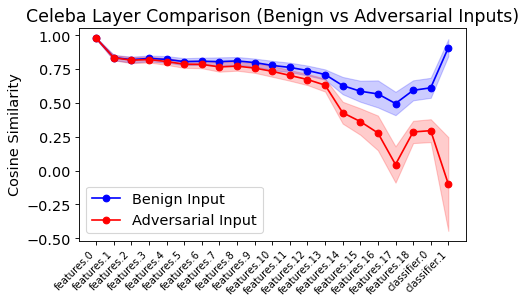

In [7]:
# Assuming the function compare_top_level_outputs_with_cosine_similarity is already defined as previously

# Example usage for Benign and Adversarial inputs
labs1, cs1, std_dev1 = compare_top_level_outputs_with_cosine_similarity(model_FAT, model_Fedavg, x_data.cuda())
labs2, cs2, std_dev2 = compare_top_level_outputs_with_cosine_similarity(model_FAT, model_Fedavg, x_adv.cuda())
# labs1, cs1, std_dev1 = compare_top_level_outputs_with_cosine_similarity_fnn(model_FAT, model_Fedavg, x_data.cuda())
# labs2, cs2, std_dev2 = compare_top_level_outputs_with_cosine_similarity_fnn(model_FAT, model_Fedavg, x_adv.cuda())

# Plotting setup
font = {'family': 'normal', 'weight': 'normal', 'size': 13}
threshold = 0.95

# Set font and figure size
plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6, 4))

# Plot Cosine Similarities for both sets of inputs
line_color1 = 'b'  # Color for benign input
line_color2 = 'r'  # Color for adversarial input

plt.plot(labs1, cs1, marker="o", color=line_color1, label="Benign Input")
plt.plot(labs2, cs2, marker="o", color=line_color2, label="Adversarial Input")

# Overlay standard deviation ranges with matching colors
plt.fill_between(labs1, 
                 np.array(cs1) - std_dev1, 
                 np.array(cs1) + std_dev1, 
                 color=line_color1, alpha=0.2)

plt.fill_between(labs2, 
                 np.array(cs2) - std_dev2, 
                 np.array(cs2) + std_dev2, 
                 color=line_color2, alpha=0.2)

# Add threshold line (optional)
# plt.axhline(y=threshold, color="r", linestyle="--", label=f"Threshold = {threshold}")

# Plot settings
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.ylabel("Cosine Similarity")
plt.title("Celeba Layer Comparison (Benign vs Adversarial Inputs)")
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

Submodule Name                 Mean Cosine Similarity         Std Dev
features.0                               0.97798049      0.00552061 
features.1                               0.89806896      0.00924663 !!!
features.2                               0.90015584      0.01830671 !!!
features.3                               0.96195936      0.00485038 
features.4                               0.94467634      0.00403314 !!!
features.5                               0.98320663      0.00129516 
features.6                               0.98918605      0.00086616 
features.7                               0.96109408      0.00323687 
features.8                               0.97902119      0.00295001 
features.9                               0.98802048      0.00166767 
features.10                              0.98355108      0.01023172 
features.11                              0.96765447      0.00221065 
features.12                              0.96797997      0.00347614 
features.13             

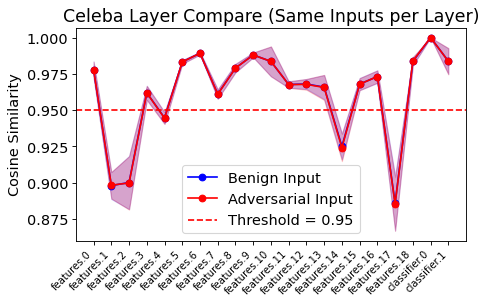

In [8]:

# Example usage for benign and adversarial inputs
labs1, cs1, std_dev1 = compare_intermediate_outputs_with_cosine_similarity(model_FAT, model_Fedavg, x_data.cuda())
labs2, cs2, std_dev2 = compare_intermediate_outputs_with_cosine_similarity(model_FAT, model_Fedavg, x_adv.cuda())

# labs1, cs1, std_dev1 = compare_intermediate_outputs_with_cosine_similarity_fnn(model_FAT, model_Fedavg, x_data.cuda())
# labs2, cs2, std_dev2 = compare_intermediate_outputs_with_cosine_similarity_fnn(model_FAT, model_Fedavg, x_adv.cuda())

# Plot cosine similarity with standard deviation range
font = {'family': 'normal', 'weight': 'normal', 'size': 13}
threshold = 0.95

# Set font and figure size
plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6, 4))

# Plot the cosine similarity curves
line_color1 = 'b'  # Benign input curve color
line_color2 = 'r'  # Adversarial input curve color

plt.plot(labs1, cs1, marker="o", color=line_color1, label="Benign Input")
plt.plot(labs2, cs2, marker="o", color=line_color2, label="Adversarial Input")

# Overlay standard deviation as shaded regions
plt.fill_between(labs1, 
                 np.array(cs1) - std_dev1, 
                 np.array(cs1) + std_dev1, 
                 color=line_color1, alpha=0.2)

plt.fill_between(labs2, 
                 np.array(cs2) - std_dev2, 
                 np.array(cs2) + std_dev2, 
                 color=line_color2, alpha=0.2)

# Optional: Add threshold line
plt.axhline(y=threshold, color="r", linestyle="--", label=f"Threshold = {threshold}")

# Plot settings
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.ylabel("Cosine Similarity")
plt.title("Celeba Layer Compare (Same Inputs per Layer)")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
model_Fedavg.state_dict().keys()

odict_keys(['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.conv.0.0.weight', 'features.1.conv.0.1.weight', 'features.1.conv.0.1.bias', 'features.1.conv.0.1.running_mean', 'features.1.conv.0.1.running_var', 'features.1.conv.0.1.num_batches_tracked', 'features.1.conv.1.weight', 'features.1.conv.2.weight', 'features.1.conv.2.bias', 'features.1.conv.2.running_mean', 'features.1.conv.2.running_var', 'features.1.conv.2.num_batches_tracked', 'features.2.conv.0.0.weight', 'features.2.conv.0.1.weight', 'features.2.conv.0.1.bias', 'features.2.conv.0.1.running_mean', 'features.2.conv.0.1.running_var', 'features.2.conv.0.1.num_batches_tracked', 'features.2.conv.1.0.weight', 'features.2.conv.1.1.weight', 'features.2.conv.1.1.bias', 'features.2.conv.1.1.running_mean', 'features.2.conv.1.1.running_var', 'features.2.conv.1.1.num_batches_tracked', 'features.2.conv.2.weight', 'fea

In [10]:
# Take measurement for FedAvg model
aggregator.load_state(dir_path=save_path_FedAvg)
aggregator.update_clients()
model_FA = pull_model_from_agg(aggregator)
model_FA.eval()
acc, adv_acc = get_adv_acc(aggregator, model_FA, eps=eps_attack, step_size = step_size, steps = steps)

print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

# Take measurement for FedAvg model
aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
model_FA = pull_model_from_agg(aggregator)
model_FA.eval()
acc, adv_acc = get_adv_acc(aggregator, model_FA, eps=eps_attack, step_size = step_size, steps = steps)

print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

Test acc:  0.799399995803833  ( 0.05217871255242397 )  adv acc:  0.0  ( 0.0 ) 
Test acc:  0.8132666707038879  ( 0.055153083927723605 )  adv acc:  0.5271000072360039  ( 0.06360408055739084 ) 


In [11]:
# # Take measurement for ARU attack
# aggregator.load_state(dir_path=save_path_FAT)
# aggregator.update_clients()
# aggregation_op = 'trimmed_mean'
# aggregator.op = aggregation_op
# weight_scale_2 = 1
# atk_rounds = 1
# tm_beta = 0

# if False:
#     print("updating adv data set")

#     # add adv dataset update
#     Fu = np.ones(num_user) * 0.5

#     # Setting evasion attack parameters
#     x_min = torch.min(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
#     x_max = torch.max(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
#     atk_params = PGD_Params()
#     atk_params.set_params(batch_size=1, iteration = steps,
#                     target = -1, x_val_min = x_min, x_val_max = x_max,
#                     step_size = step_size, step_norm = "inf", eps = eps_train, eps_norm = 2)

#     # Assign proportion and attack params
#     for c in range(len(aggregator.clients)):
#         if Fu[c] > 0:
#             # print (c)
#             aggregator.clients[c].set_adv_params(Fu[c], atk_params)
#             aggregator.clients[c].update_advnn()

#             aggregator.clients[c].assign_advdataset()


# for i in range(atk_rounds):
#     print('round ', i)
#     UNL_mix(aggregator, adv_id=[0], model_inject=model_FAT, weight_scale_2 = weight_scale_2, keys=desired_keys, aggregation_op = aggregation_op, tm_beta = tm_beta)


# model_overfit = pull_model_from_agg(aggregator)
# model_overfit.eval()
# acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps=eps_attack, step_size = step_size, steps = steps)
# print("TRIMMED MEAN")
# print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

In [12]:
# dataloader = load_client_data(clients = aggregator.clients, c_id = 0, mode = 'test')
# x_data = dataloader.x_data
# y_data = dataloader.y_data
# # Example usage
# _ = compare_layer_outputs_with_cosine_similarity(model_Fedavg, model_overfit, x_data.cuda())

In [ ]:
# model_overfit.state_dict()['features.0.1.weight']

NameError: name 'model_overfit' is not defined

In [ ]:
model_overfit

In [ ]:
# # Take measurement for ARU attack
# aggregator.load_state(dir_path=save_path_FAT)
# aggregator.update_clients()
# aggregator.op = None
# weight_scale_2 = 1
# atk_rounds = 1
# aggregation_op = 'median'

# for i in range(atk_rounds):
#     print('round ', i)
#     UNL_mix(aggregator, adv_id=[0], model_inject=model_Fedavg, weight_scale_2 = weight_scale_2, keys=desired_keys, aggregation_op = aggregation_op)

# model_overfit = pull_model_from_agg(aggregator)
# model_overfit.eval()
# acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps=eps_attack, step_size = step_size, steps = steps)
# print("MEDIAN")
# print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

round  0
